# Spark

In [0]:
# Google preinstalled packages
import pandas as pd
import time

In [0]:
# install Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# init Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
airports_dfs = spark.read.csv("/content/gdrive/My Drive/Colab Notebooks/SparkAzureTutorial/data/airports.csv", header=True, inferSchema=True)
airports_dfs.show(5, False)

+----------+-----------+-----+-----------------------------------+
|airport_id|city       |state|name                               |
+----------+-----------+-----+-----------------------------------+
|10165     |Adak Island|AK   |Adak                               |
|10299     |Anchorage  |AK   |Ted Stevens Anchorage International|
|10304     |Aniak      |AK   |Aniak Airport                      |
|10754     |Barrow     |AK   |Wiley Post/Will Rogers Memorial    |
|10551     |Bethel     |AK   |Bethel Airport                     |
+----------+-----------+-----+-----------------------------------+
only showing top 5 rows



In [0]:
flights_dfs = spark.read.csv("/content/gdrive/My Drive/Colab Notebooks/SparkAzureTutorial/data/raw-flight-data.csv", header=True, inferSchema=True)
flights_dfs.show(5, False)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|19        |5        |DL     |11433          |13303        |-3      |1       |
|19        |5        |DL     |14869          |12478        |0       |-8      |
|19        |5        |DL     |14057          |14869        |-4      |-15     |
|19        |5        |DL     |15016          |11433        |28      |24      |
|19        |5        |DL     |11193          |12892        |-6      |-11     |
+----------+---------+-------+---------------+-------------+--------+--------+
only showing top 5 rows



In [0]:
airports_dfs.printSchema()

root
 |-- airport_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)



In [0]:
flights_dfs.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)



In [0]:
flights_dfs.createOrReplaceTempView("flights_sql")
airports_dfs.createOrReplaceTempView("airports_sql")

In [0]:
start_time = time.time()
spark.sql("""
SELECT city, count(city) 
FROM flights_sql 
INNER JOIN airports_sql ON flights_sql.DestAirportID = airports_sql.airport_id
GROUP BY city
ORDER BY count(city) DESC
LIMIT 10""").show(truncate = False)
print("--- {} seconds ---".format(time.time() - start_time))

+-----------------+-----------+
|city             |count(city)|
+-----------------+-----------+
|Chicago          |177703     |
|Atlanta          |150029     |
|Los Angeles      |119062     |
|New York         |118282     |
|Dallas/Fort Worth|104730     |
|Houston          |103030     |
|Denver           |97264      |
|Phoenix          |90360      |
|San Francisco    |84397      |
|Washington       |81163      |
+-----------------+-----------+

--- 5.429871559143066 seconds ---


# Preprocessing

In [0]:
flights_dfs.describe().show()

+-------+-----------------+------------------+-------+------------------+------------------+-----------------+-----------------+
|summary|       DayofMonth|         DayOfWeek|Carrier|   OriginAirportID|     DestAirportID|         DepDelay|         ArrDelay|
+-------+-----------------+------------------+-------+------------------+------------------+-----------------+-----------------+
|  count|          2719418|           2719418|2719418|           2719418|           2719418|          2691974|          2690385|
|   mean|15.79747468024408|3.8983907586108497|   null| 12742.26441172339|12742.455345592329|10.53686662649788| 6.63768791455498|
| stddev|8.799860168985367|1.9859881390373617|   null|1501.9729397025808|1501.9692528927785|36.09952806643081|38.64881489390021|
|    min|                1|                 1|     9E|             10140|             10140|              -63|              -94|
|    max|               31|                 7|     YV|             15376|             15376|     

In [0]:
raw_no_rows = flights_dfs.count()
no_duplicates = raw_no_rows - flights_dfs.dropDuplicates().count()
no_duplicates

22435

In [0]:
no_missing = raw_no_rows - flights_dfs.dropna(how="any", subset=["ArrDelay", "DepDelay"]).count()
no_missing

29033

In [0]:
flights_dfs_clean = flights_dfs.dropDuplicates().fillna(value=0, subset=["ArrDelay", "DepDelay"])
assert raw_no_rows - no_duplicates == flights_dfs_clean.count()

In [0]:
flights_dfs_clean.corr("ArrDelay", "DepDelay")

0.9392630367706957

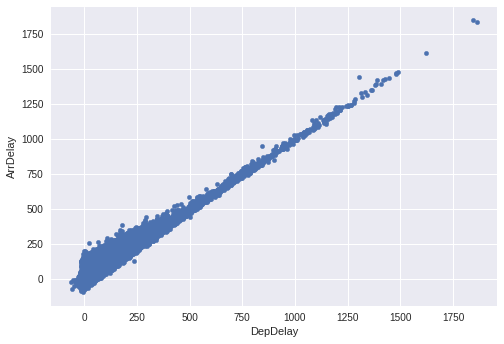

In [0]:
df = spark.sql("SELECT ArrDelay, DepDelay from flights_sql")
df = df.toPandas()
df.plot(kind="scatter", x="DepDelay", y="ArrDelay")

# Pandas Comparison

In [0]:
flights_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SparkAzureTutorial/data/raw-flight-data.csv", header=0)
flights_df.describe()

,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,DepDelay,ArrDelay
count,2.719418e+06,2.719418e+06,2.719418e+06,2.719418e+06,2.691974e+06,2.690385e+06
mean,1.579747e+01,3.898391e+00,1.274226e+04,1.274246e+04,1.053687e+01,6.637688e+00
std,8.799860e+00,1.985988e+00,1.501973e+03,1.501969e+03,3.609953e+01,3.864881e+01
min,1.000000e+00,1.000000e+00,1.014000e+04,1.014000e+04,-6.300000e+01,-9.400000e+01
25%,8.000000e+00,2.000000e+00,1.129200e+04,1.129200e+04,-4.000000e+00,-1.100000e+01
50%,1.600000e+01,4.000000e+00,1.289200e+04,1.289200e+04,-1.000000e+00,-3.000000e+00
75%,2.300000e+01,6.000000e+00,1.405700e+04,1.405700e+04,9.000000e+00,1.000000e+01
max,3.100000e+01,7.000000e+00,1.537600e+04,1.537600e+04,1.863000e+03,1.845000e+03


In [0]:
flights_df.head(5)

,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,DepDelay,ArrDelay
0,19,5,DL,11433,13303,-3.0,1.0
1,19,5,DL,14869,12478,0.0,-8.0
2,19,5,DL,14057,14869,-4.0,-15.0
3,19,5,DL,15016,11433,28.0,24.0
4,19,5,DL,11193,12892,-6.0,-11.0


In [0]:
flights_df.columns

Index(['DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID',
       'DestAirportID', 'DepDelay', 'ArrDelay'],
      dtype='object')

In [0]:
airports_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SparkAzureTutorial/data/airports.csv", header=0)
airports_df.describe()

,airport_id
count,365.000000
mean,12761.016438
std,1660.796638
min,10135.000000
25%,11292.000000
50%,12523.000000
75%,14193.000000
max,16440.000000


In [0]:
airports_df.head(5)

,airport_id,city,state,name
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport


In [0]:
airports_df.columns

Index(['airport_id', 'city', 'state', 'name'], dtype='object')

In [0]:
airports_df.columns = ['DestAirportID', 'city', 'state', 'name']
start_time = time.time()
airports_flights_df = flights_df.merge(airports_df, how="left", on="DestAirportID")
print(airports_flights_df.groupby("city")["city"].agg(["count"]).sort_values(by="count", ascending=False).head(10))
print("--- {} seconds ---".format(time.time() - start_time))

                    count
city                     
Chicago            177703
Atlanta            150029
Los Angeles        119062
New York           118282
Dallas/Fort Worth  104730
Houston            103030
Denver              97264
Phoenix             90360
San Francisco       84397
Washington          81163
--- 1.2761781215667725 seconds ---


In [0]:
airports_flights_df.head(5)

,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,DepDelay,ArrDelay,city,state,name
0,19,5,DL,11433,13303,-3.0,1.0,Miami,FL,Miami International
1,19,5,DL,14869,12478,0.0,-8.0,New York,NY,John F. Kennedy International
2,19,5,DL,14057,14869,-4.0,-15.0,Salt Lake City,UT,Salt Lake City International
3,19,5,DL,15016,11433,28.0,24.0,Detroit,MI,Detroit Metro Wayne County
4,19,5,DL,11193,12892,-6.0,-11.0,Los Angeles,CA,Los Angeles International
